In [1]:
import itertools
import json
import os
from typing import List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm

## Построение итогового датафрейма

In [2]:
# labels = pd.read_csv("data/labels.csv", names=["model", "label"], skiprows=1)
# labels.head()

model   label
0  b5025746-e58f-4696-837c-5b21808b7ae9   Torus
1  30a730ca-c466-4e8c-b00b-bf7b317495e2    Cone
2  7d0c7362-1e8d-4008-b444-cdf111e06ce9  Sphere
3  d58d68a4-7acb-48d8-96bd-71f1eca1affe  Sphere
4  df907d43-7c4f-4ccd-9350-0d84c41dba54    Cube

In [3]:
# labels.label.unique()

array(['Torus', 'Cone', 'Sphere', ..., 'Torus.2032', 'Torus.2033',
       'Torus.2034'], dtype=object)

In [4]:
def clean_types(data: pd.DataFrame) -> pd.DataFrame:
    data.label = data.label.apply(lambda x: x.split('.')[0])
    return data

In [5]:
# labels = clean_types(labels)
# labels.label.unique()

array(['Torus', 'Cone', 'Sphere', 'Cube', 'Cylinder'], dtype=object)

In [6]:
def load_histograms(dir_path: str) -> List[Union[str, int, List[float]]]:  
    data = []
    
    for hist_name in os.listdir(dir_path):
        with open(os.path.join(dir_path, hist_name), 'r') as f:
            name = hist_name.split('.')[0]
            hist_file = json.load(f)
            
            for hist in hist_file["histogram_data"]:
                cur_data = [name, hist["type"], hist["intervals"], hist["data"]]
                data.append(cur_data)
                
    return data

In [7]:
# data = load_histograms("data/histograms")

In [8]:
# hist_df = pd.DataFrame(data, columns=["model", "hist_type", "bins", "data"])
# hist_df.head()

model  \
0  11c5e331-a33e-4350-b72b-cdc0df89c1ed   
1  11c5e331-a33e-4350-b72b-cdc0df89c1ed   
2  11c5e331-a33e-4350-b72b-cdc0df89c1ed   
3  11c5e331-a33e-4350-b72b-cdc0df89c1ed   
4  11c5e331-a33e-4350-b72b-cdc0df89c1ed   

                                     hist_type  bins  \
0           model_bounding_sphere_strict_outer     8   
1  model_bounding_sphere_strict_outer_absolute     8   
2                 model_bounding_sphere_missed     8   
3      model_bounding_sphere_concentric_sphere     8   
4           model_bounding_sphere_strict_outer    16   

                                                data  
0  [0.1349800995912831, 0.15335719002659337, 0.28...  
1  [0.04169448485854208, 0.047371049931609975, 0....  
2  [0, 0, 0.07517723367882632, 0.1657911677918522...  
3  [0, 0.06527780256652804, 0.14161684127862356, ...  
4  [0.031147263024505167, 0.10383283656677791, 0....

In [9]:
# result = pd.merge(hist_df, labels, how="left", on=["model", "model"])
# result.shape

(63960, 5)

In [19]:
# result.to_csv("data/data.csv", index=False)

In [22]:
result = pd.read_csv("data/data.csv")
result.head()

model  \
0  11c5e331-a33e-4350-b72b-cdc0df89c1ed   
1  11c5e331-a33e-4350-b72b-cdc0df89c1ed   
2  11c5e331-a33e-4350-b72b-cdc0df89c1ed   
3  11c5e331-a33e-4350-b72b-cdc0df89c1ed   
4  11c5e331-a33e-4350-b72b-cdc0df89c1ed   

                                     hist_type  bins  \
0           model_bounding_sphere_strict_outer     8   
1  model_bounding_sphere_strict_outer_absolute     8   
2                 model_bounding_sphere_missed     8   
3      model_bounding_sphere_concentric_sphere     8   
4           model_bounding_sphere_strict_outer    16   

                                                data     label  
0  [0.1349800995912831, 0.15335719002659337, 0.28...  Cylinder  
1  [0.04169448485854208, 0.047371049931609975, 0....  Cylinder  
2  [0, 0, 0.07517723367882632, 0.1657911677918522...  Cylinder  
3  [0, 0.06527780256652804, 0.14161684127862356, ...  Cylinder  
4  [0.031147263024505167, 0.10383283656677791, 0....  Cylinder

In [10]:
result.hist_type.unique()

array(['model_bounding_sphere_strict_outer',
       'model_bounding_sphere_strict_outer_absolute',
       'model_bounding_sphere_missed',
       'model_bounding_sphere_concentric_sphere',
       'hull_bounding_sphere_strict_outer',
       'hull_bounding_sphere_strict_outer_absolute',
       'hull_bounding_sphere_missed',
       'hull_bounding_sphere_concentric_sphere'], dtype=object)

In [11]:
result.bins.unique()

array([  8,  16,  32,  64, 128])

In [12]:
def select_data(data: pd.DataFrame, config: Tuple[Tuple[str, int]]) -> pd.DataFrame:
    def f(x1, x2, x1_val, x2_val):
        return x1 == x1_val and x2 == x2_val
        
    mask = None
    for t, b in config:
        cur_mask = result.apply(lambda x: f(x.hist_type, x.bins, t, b), axis=1)
        if mask is None:
            mask = cur_mask
        mask = mask | cur_mask

    cur_data = data[mask]
    cur_data = cur_data[["model", "data", "label"]]
    cur_data = cur_data.groupby(["model", "label"]).agg(sum)
    cur_data = cur_data.reset_index()
    
    return cur_data

In [13]:
def get_data(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, pd.Series]:
    X_data = np.vstack(df["data"].values)
    
    kmeans = KMeans(n_clusters=len(df.label.unique()), random_state=12345).fit(X_data)
    predicted_labels = kmeans.predict(X_data)
    
    pca = PCA(n_components=2)
    X_2 = pca.fit_transform(X_data)
    
    return X_2, predicted_labels, df.label

In [14]:
def plot(X_data: np.ndarray, predicted_labels: np.ndarray, ground_truth_labels: pd.Series):
    fig, axs = plt.subplots(1, 2, figsize=(21,7), dpi=256)
    
    for l1, l2 in zip(np.unique(predicted_labels), np.unique(ground_truth_labels)):
        axs[0].scatter(X_data[predicted_labels==l1, 0], X_data[predicted_labels==l1, 1], label=l1, s=20)
        axs[1].scatter(X_data[ground_truth_labels==l2, 0], X_data[ground_truth_labels==l2, 1], label=l2, s=20)
    
    axs[0].title.set_text('KMeans labels')
    axs[1].title.set_text('Ground truth labels')
    axs[0].legend()
    axs[1].legend()
    
    plt.tight_layout()

Для оценки качества кластеризации использую долю преобладающего класса в кластере.

In [15]:
def perfomance(predicted_labels: np.ndarray, ground_truth_labels: pd.Series) -> List[float]:
    result = []
    for l1 in np.unique(predicted_labels):
        cluster_stat = ground_truth_labels[predicted_labels == l1].value_counts()
        count = cluster_stat[cluster_stat.argmax()]
        result.append(count / cluster_stat.sum())
    return result

Рассмотрим все возможные комбинации гистограмм с `8` и `16` бинами. Максимальное число гистограмм в комбинации равно `4`. Для каждой комбинации измерим качество кластеризации, предложенным выше способом. Затем изобразим кластеры на плоскости, используя `PCA` для понижения размерности.

In [16]:
combinations = list(itertools.product(result.hist_type.unique(), [8, 16]))

cluster_results = []

for L in range(1, 5):
    for config in tqdm(list(itertools.combinations(combinations, L))):
        cur_df = select_data(result, config)
        X_2, predicted_labels, ground_truth_labels = get_data(cur_df)
        res = perfomance(predicted_labels, ground_truth_labels)
        cluster_results.append([(X_2, predicted_labels, ground_truth_labels, config), (min(res), np.mean(res), max(res))])

100%|██████████| 1820/1820 [2:51:51<00:00,  5.67s/it]  


In [31]:
def log_info(data):
    for res in data[:3]:
        X_2, predicted_labels, ground_truth_labels, config = res[0]
        print('Config:')
        for el in config:
            print('\t', *el)
        print()
        print(f"min {round(res[1][0], 3)}, mean {round(res[1][1], 3)}, max {round(res[1][2], 3)}")
        plot(X_2, predicted_labels, ground_truth_labels)
        plt.show()

Отсортируем по минимальному значению.

Config:
	 model_bounding_sphere_strict_outer 8
	 model_bounding_sphere_concentric_sphere 16
	 hull_bounding_sphere_strict_outer_absolute 8

min 0.308, mean 0.391, max 0.704


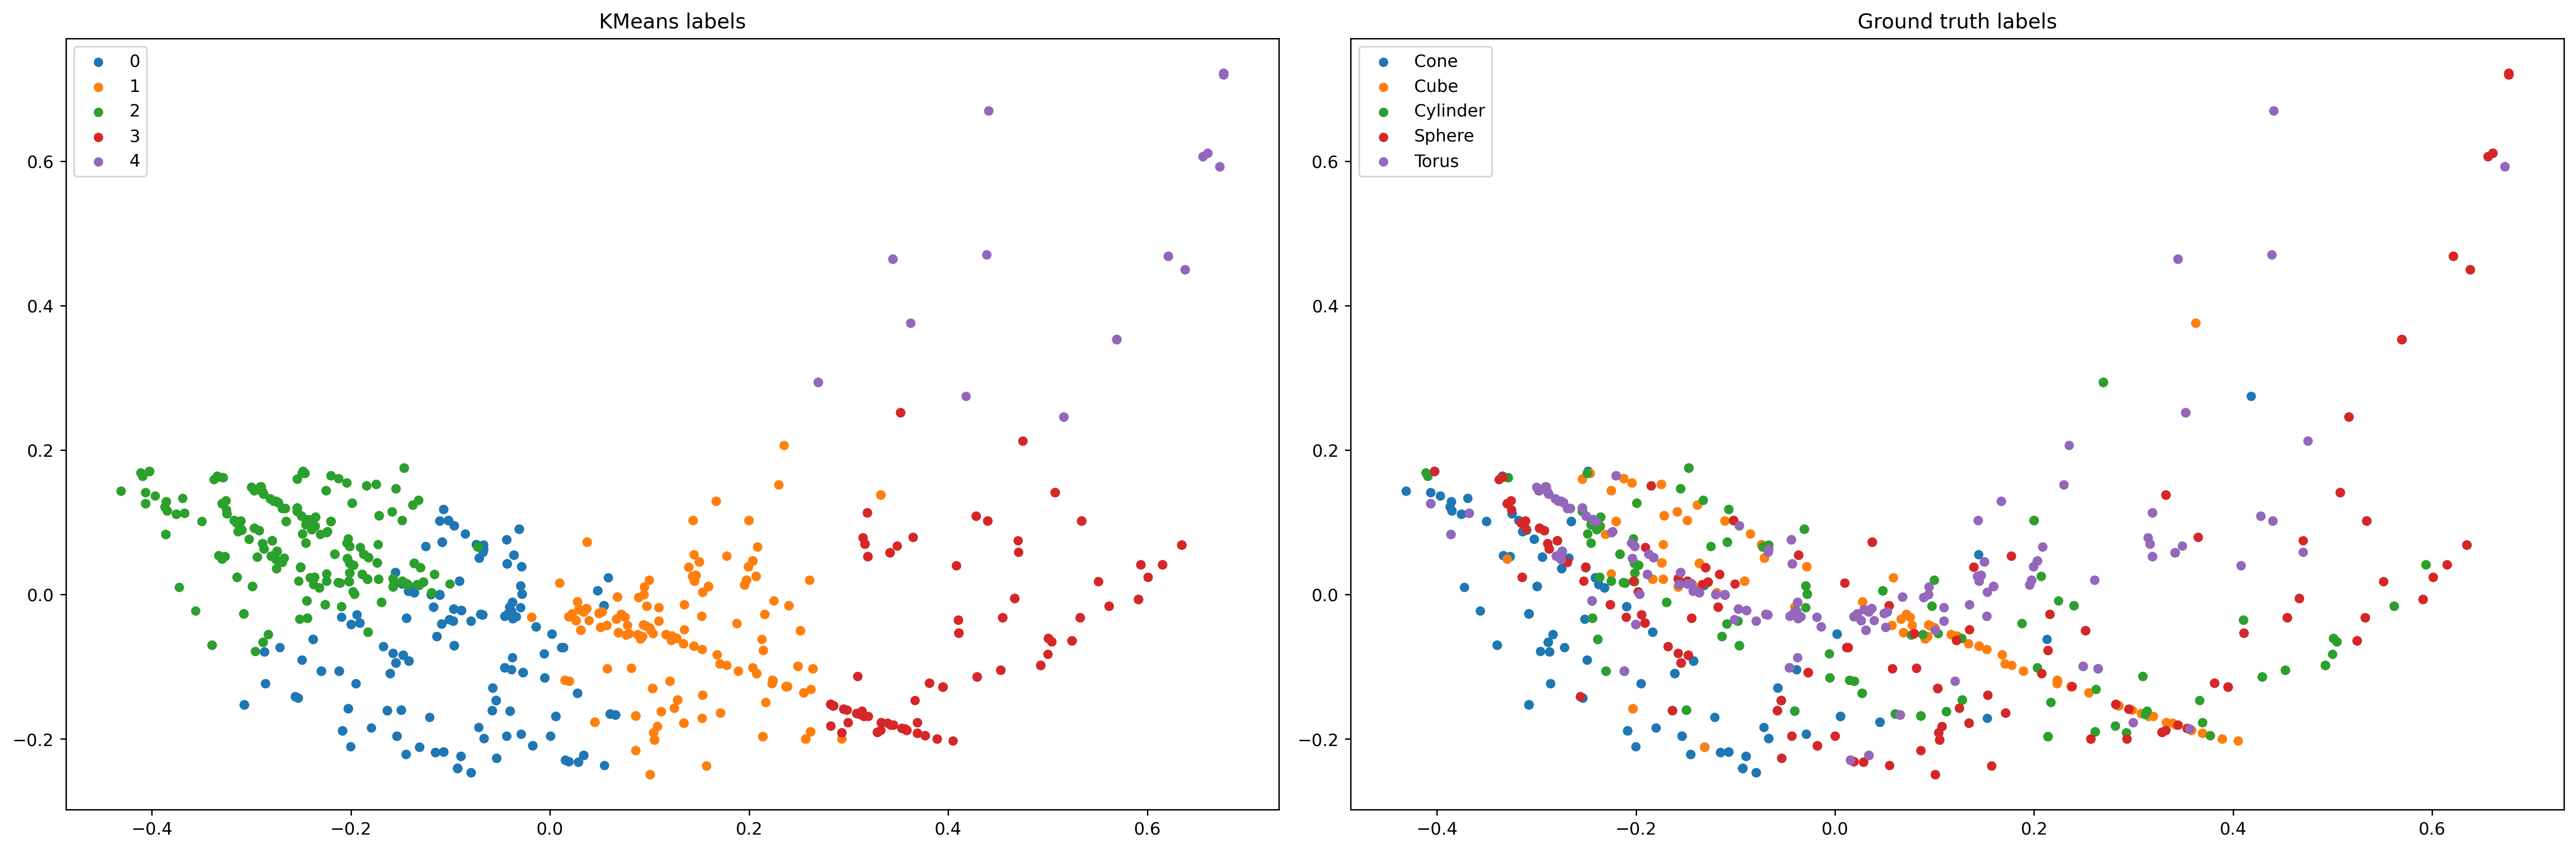

Config:
	 model_bounding_sphere_strict_outer 8
	 model_bounding_sphere_strict_outer_absolute 8
	 model_bounding_sphere_concentric_sphere 16
	 hull_bounding_sphere_strict_outer_absolute 16

min 0.304, mean 0.402, max 0.704


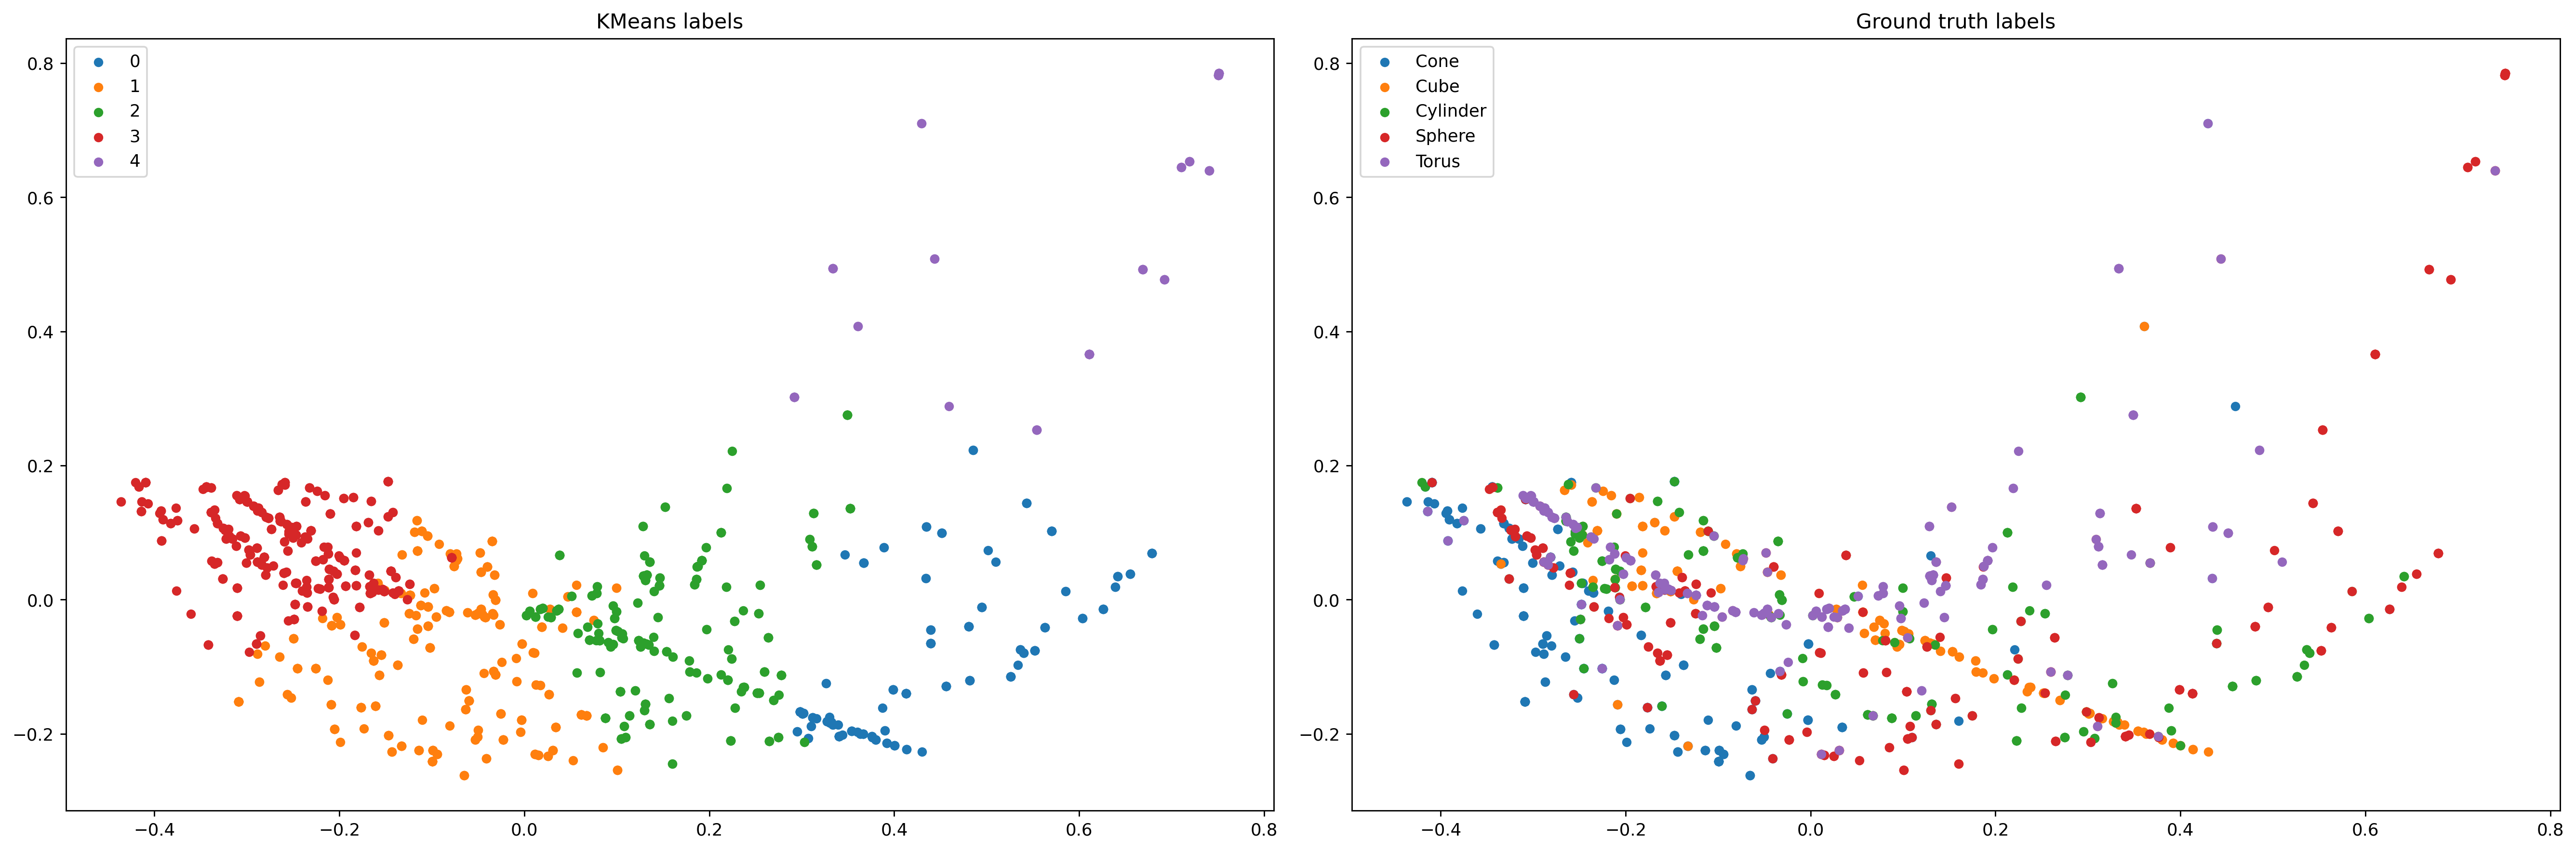

Config:
	 model_bounding_sphere_strict_outer 8
	 model_bounding_sphere_strict_outer_absolute 16
	 model_bounding_sphere_concentric_sphere 16
	 hull_bounding_sphere_strict_outer_absolute 16

min 0.303, mean 0.402, max 0.704


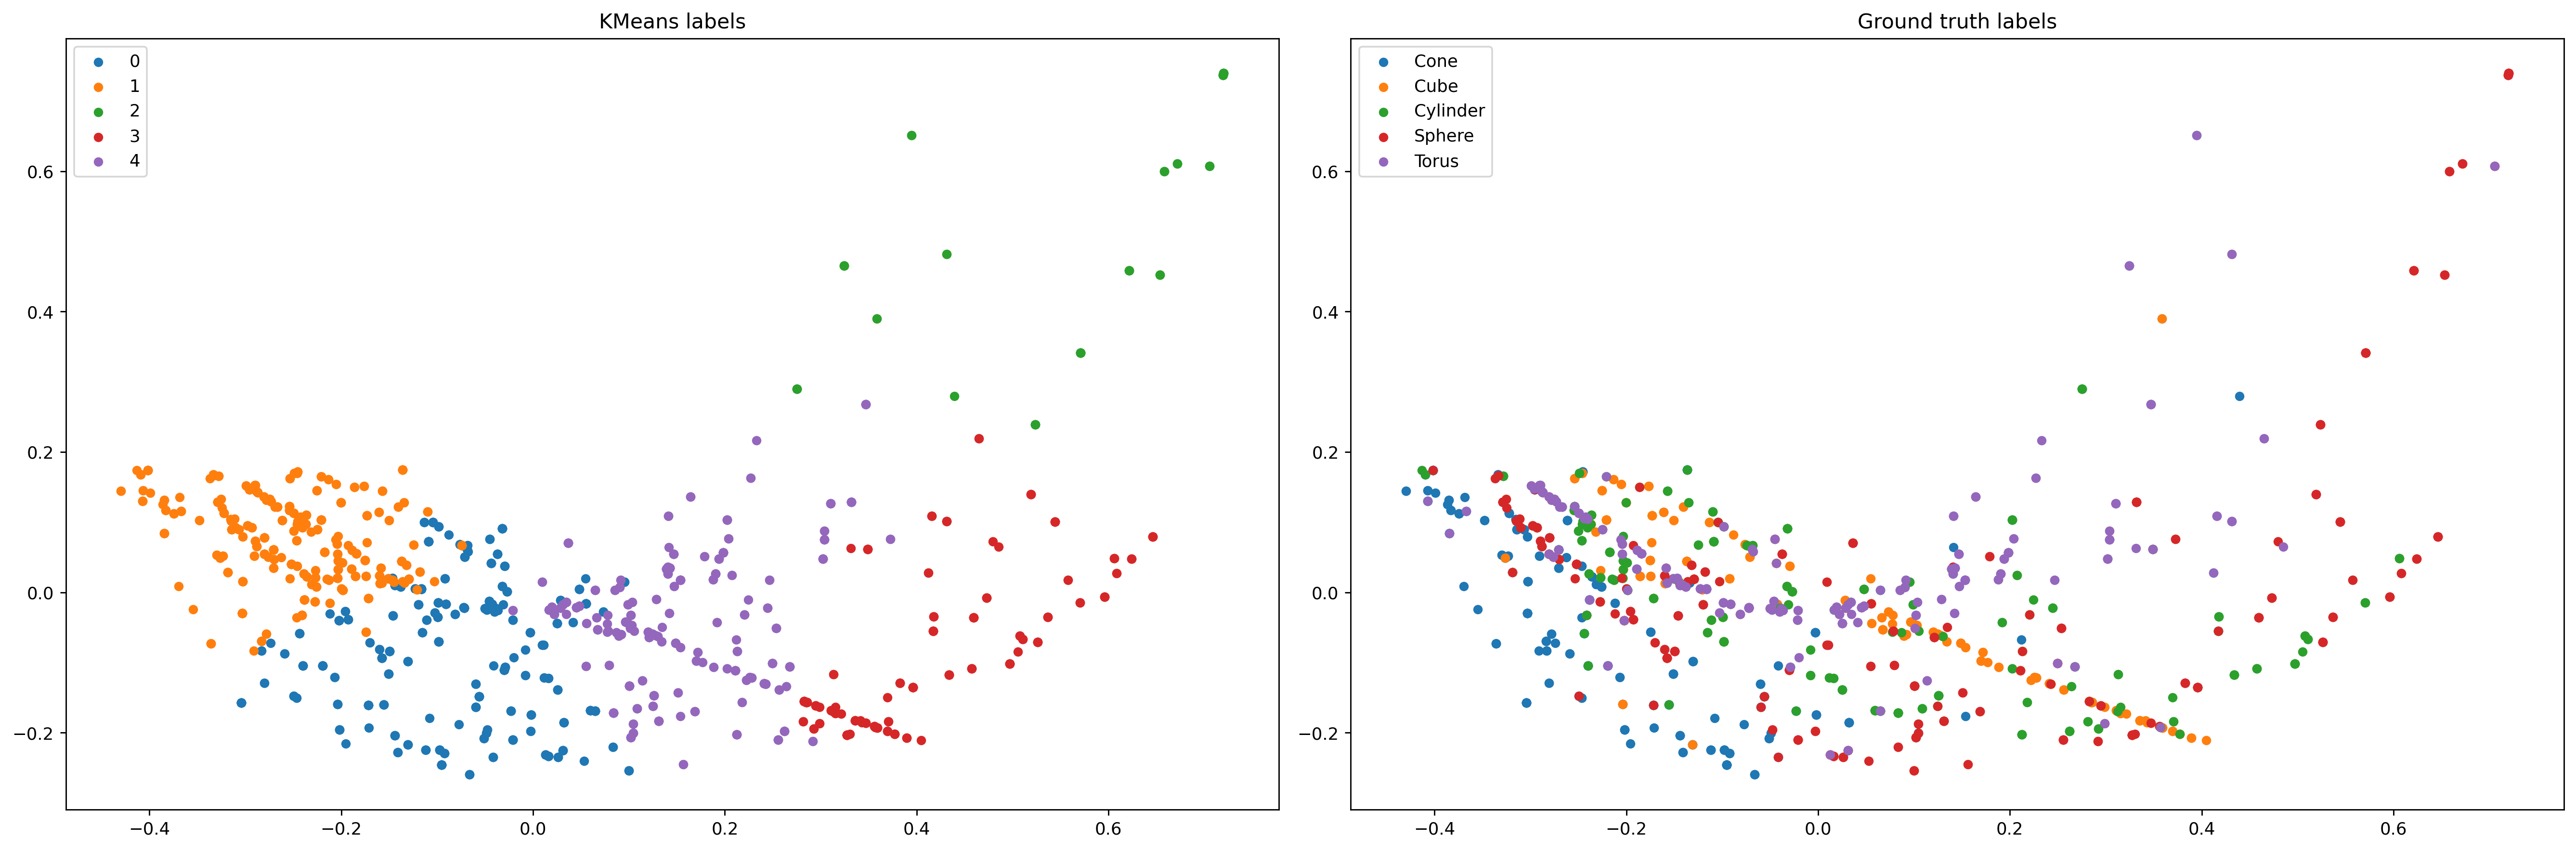

In [33]:
cluster_results.sort(key=lambda x: (x[1][0], x[1][1], x[1][2]), reverse=True)
log_info(cluster_results)

Отсортируем по среднему значению.

Config:
	 model_bounding_sphere_missed 8
	 model_bounding_sphere_missed 16
	 hull_bounding_sphere_missed 8

min 0.245, mean 0.548, max 0.957


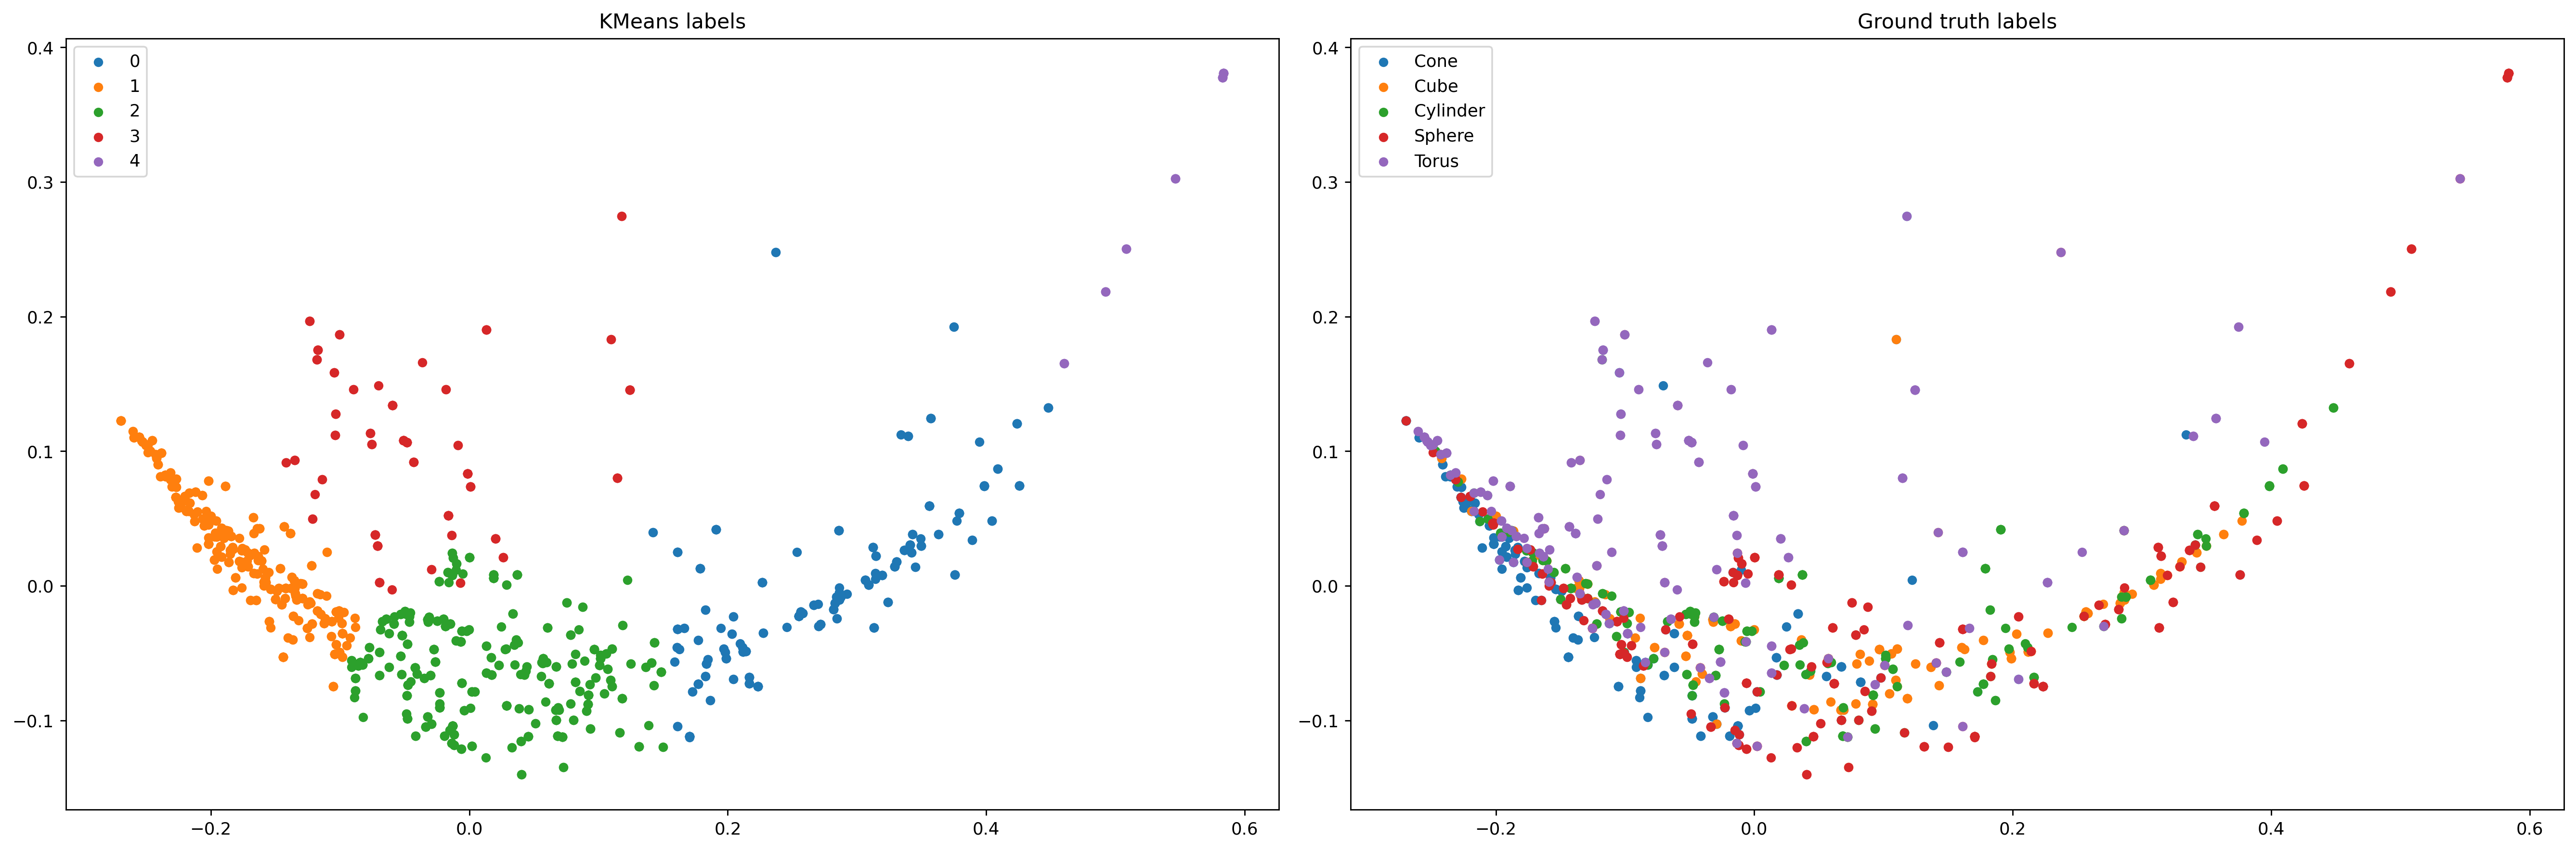

Config:
	 model_bounding_sphere_missed 8
	 model_bounding_sphere_missed 16
	 hull_bounding_sphere_missed 16

min 0.243, mean 0.547, max 0.957


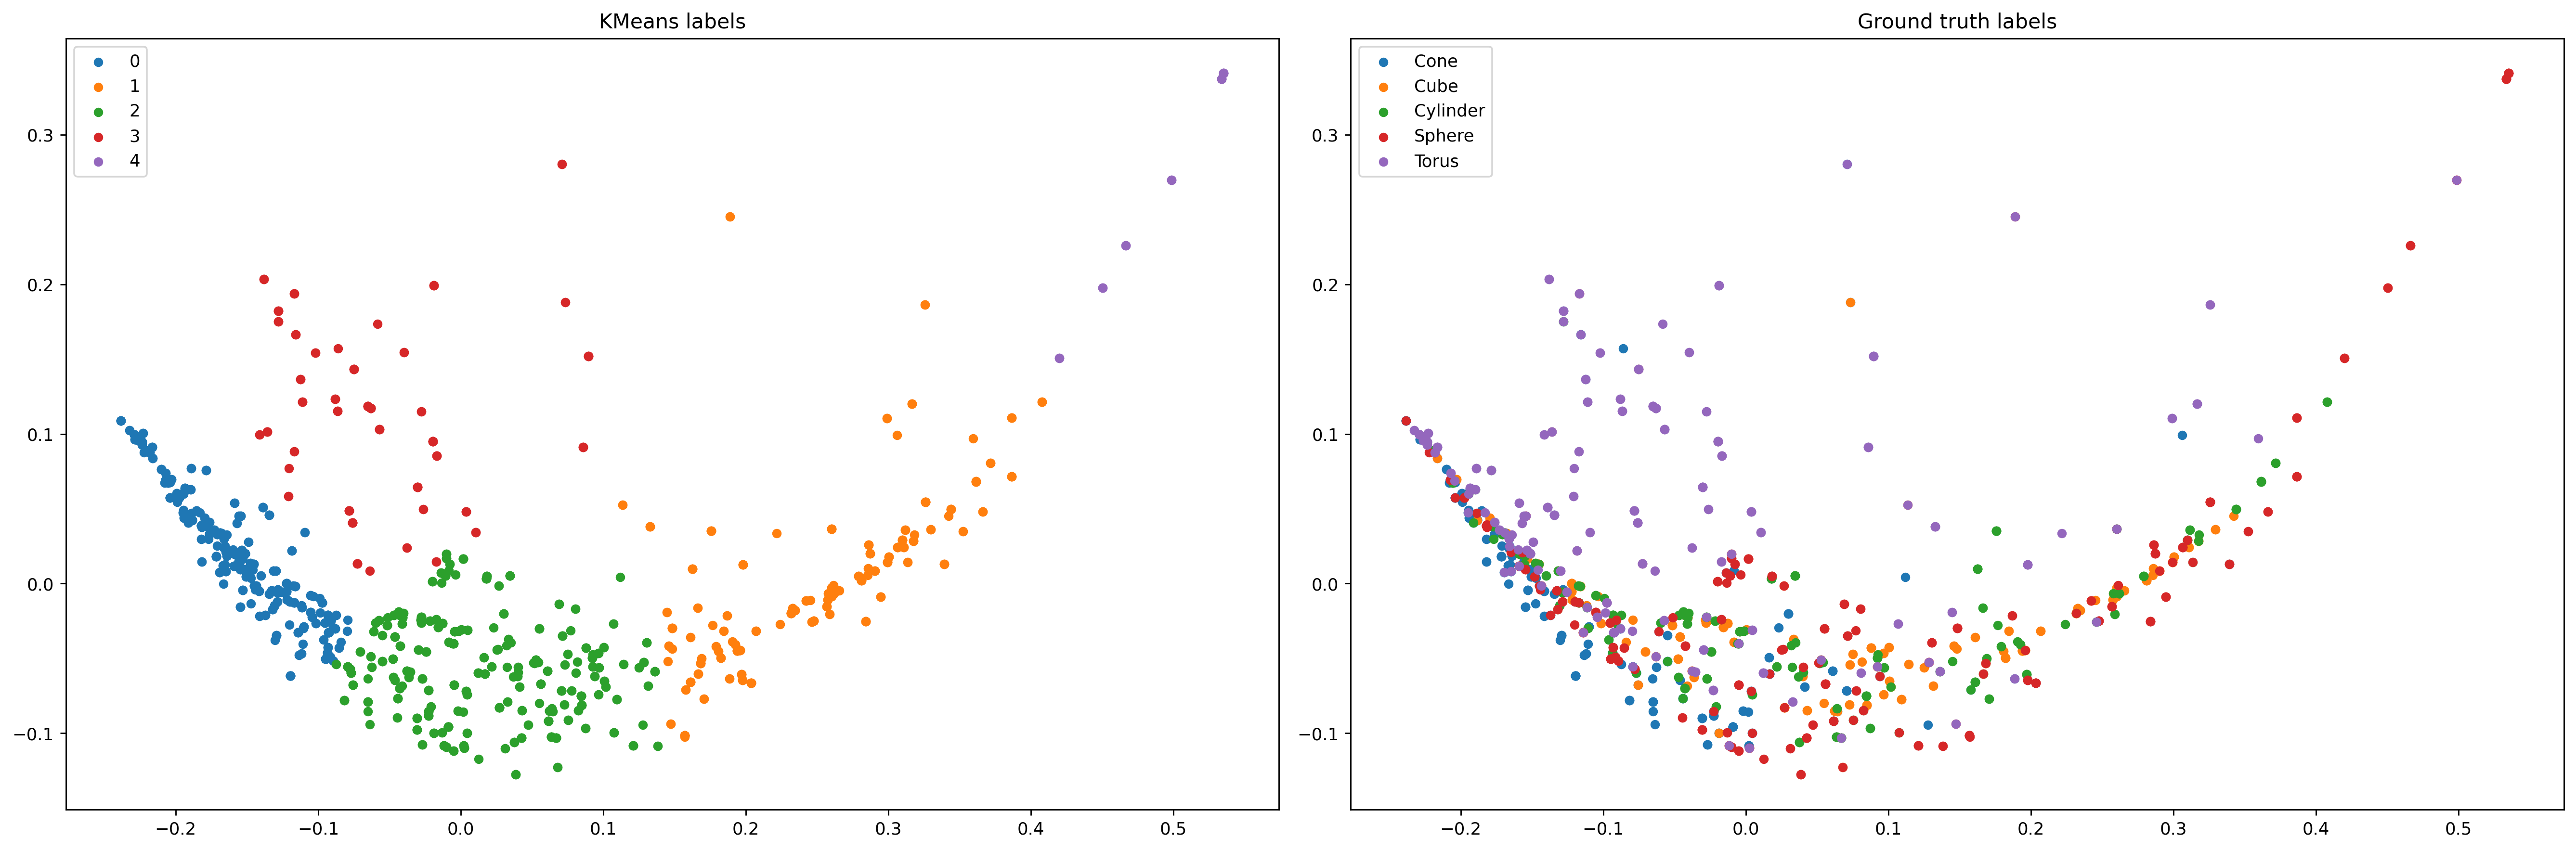

Config:
	 model_bounding_sphere_missed 16

min 0.245, mean 0.546, max 0.957


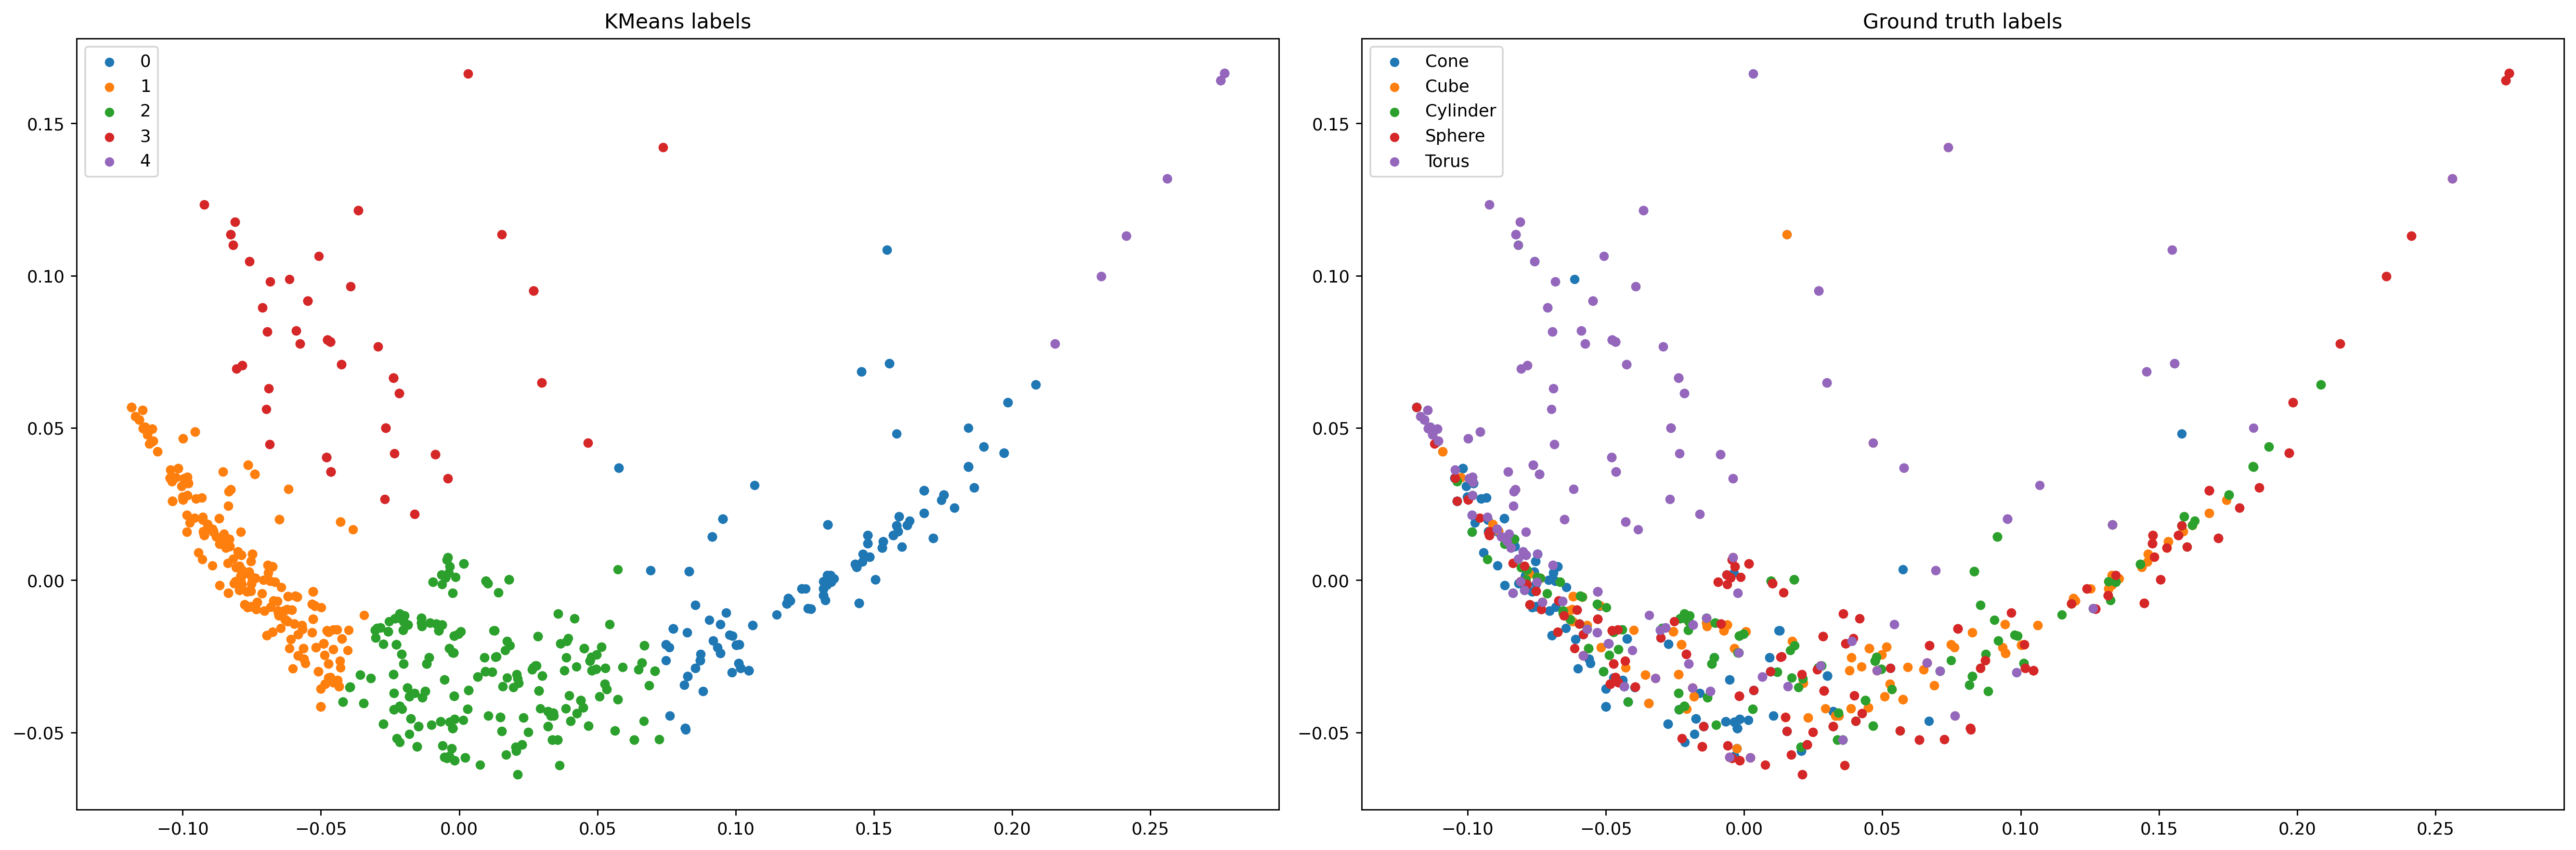

In [34]:
cluster_results.sort(key=lambda x: (x[1][1], x[1][0], x[1][2]), reverse=True)
log_info(cluster_results)

Config:
	 model_bounding_sphere_missed 8
	 model_bounding_sphere_missed 16
	 hull_bounding_sphere_missed 8

min 0.245, mean 0.548, max 0.957


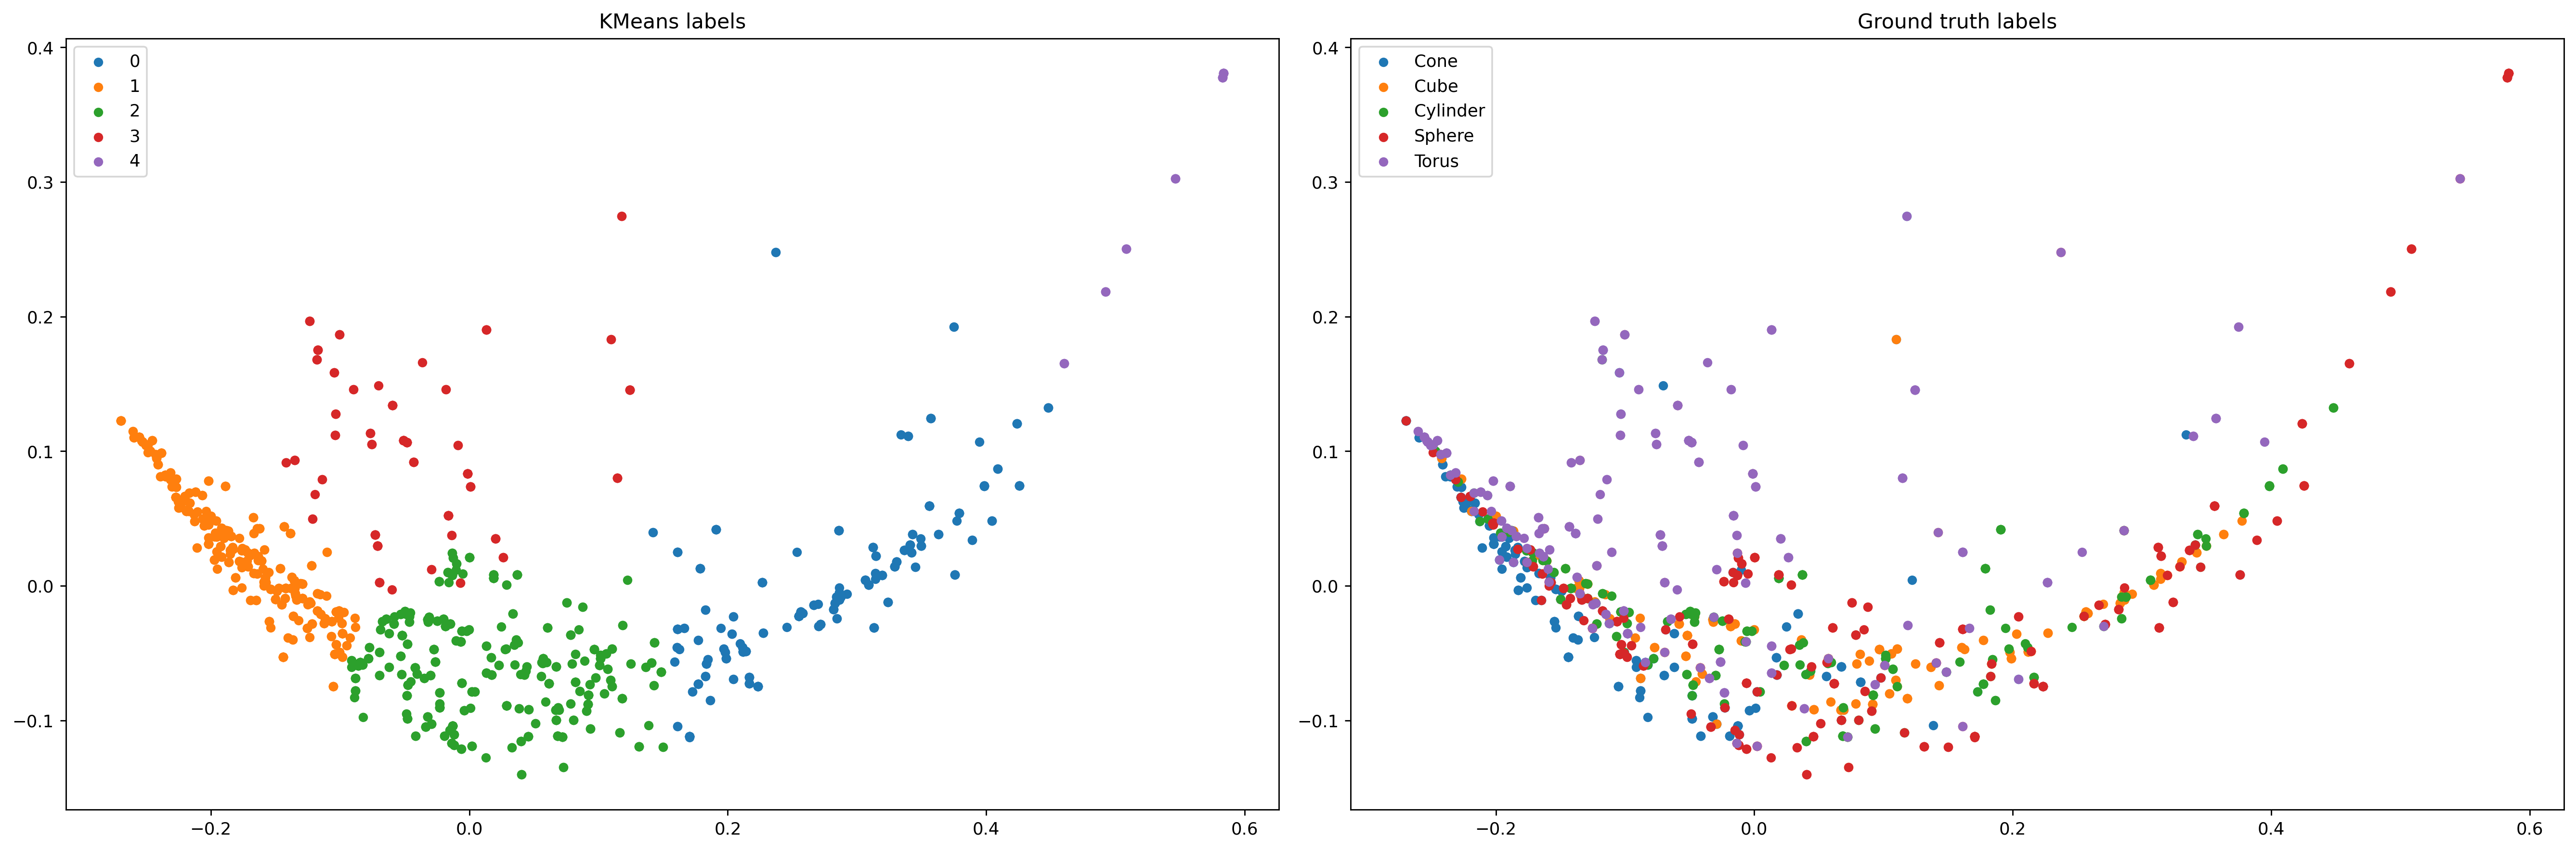

Config:
	 model_bounding_sphere_missed 8
	 model_bounding_sphere_missed 16
	 hull_bounding_sphere_missed 16

min 0.243, mean 0.547, max 0.957


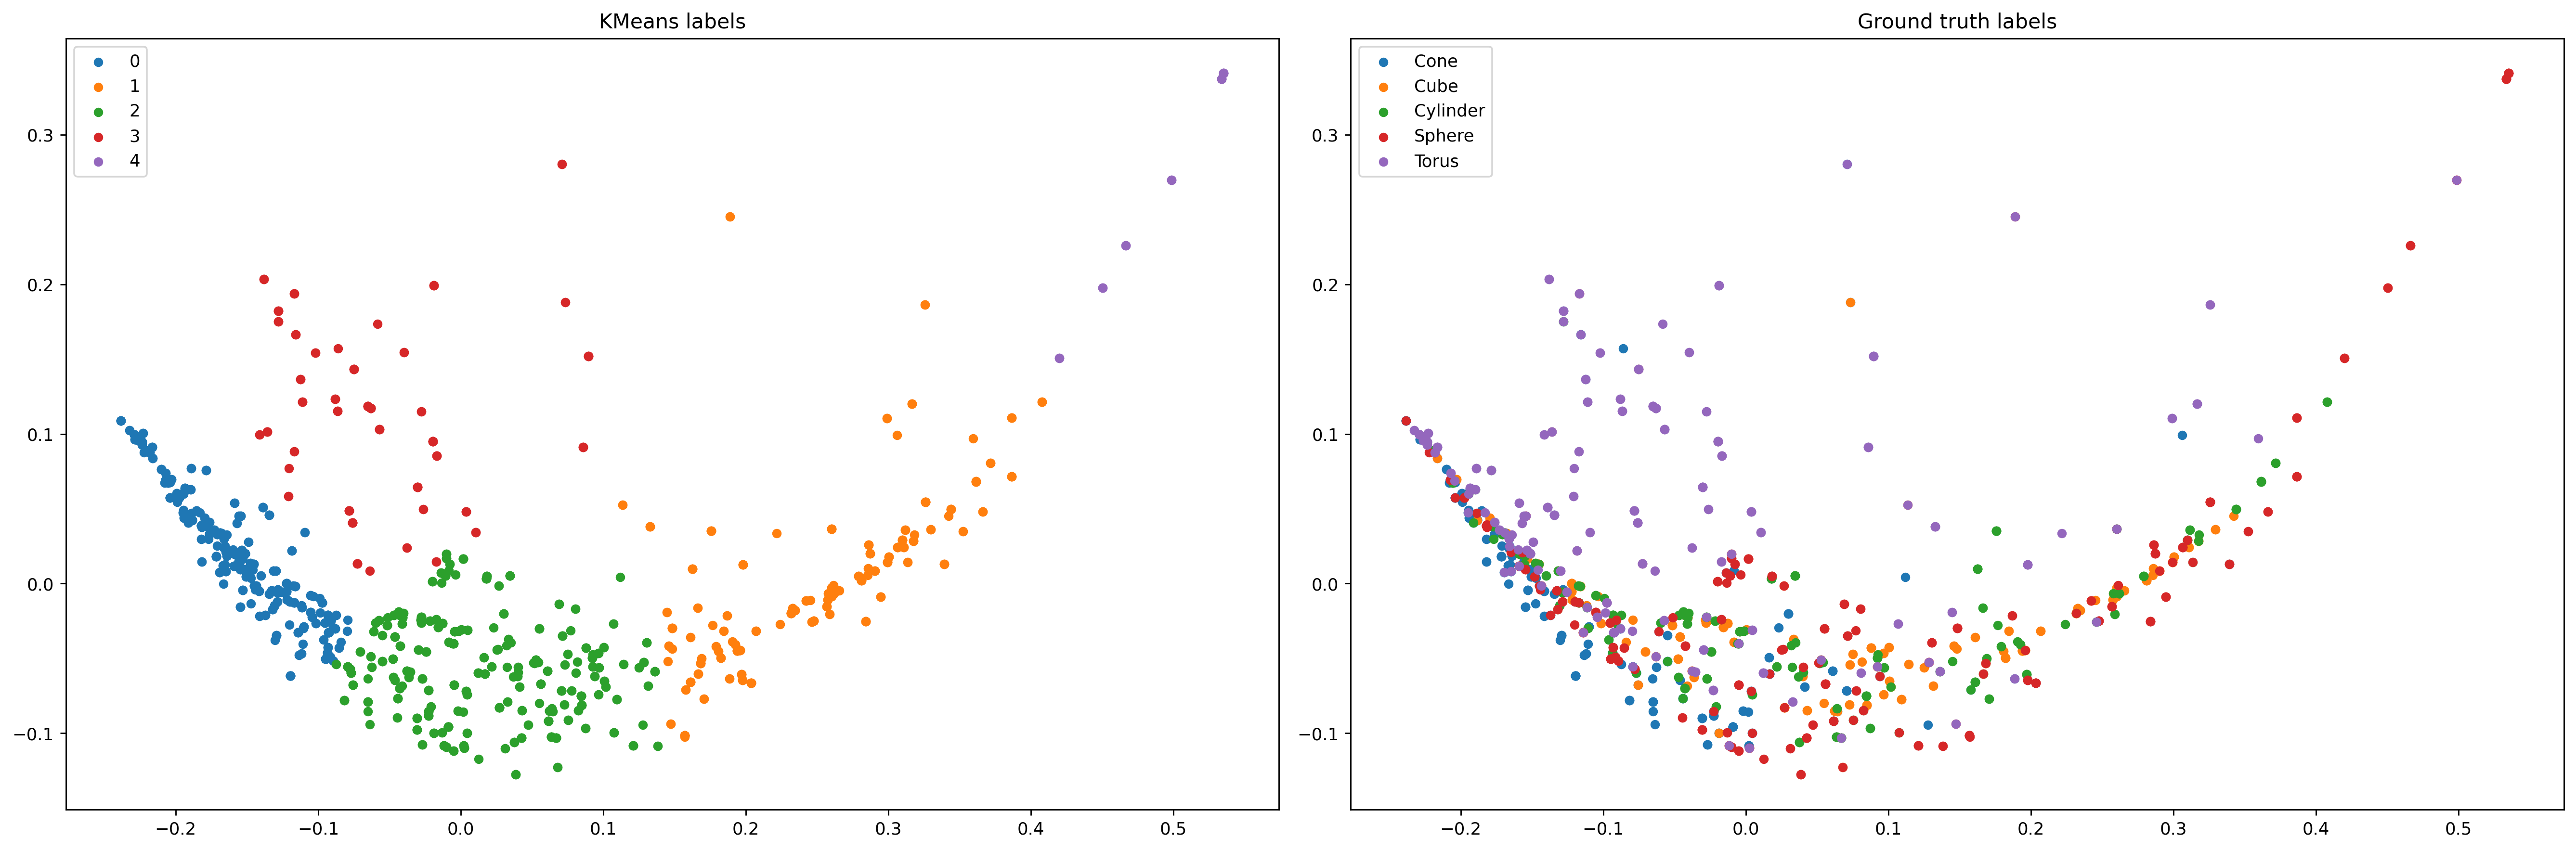

Config:
	 model_bounding_sphere_missed 16

min 0.245, mean 0.546, max 0.957


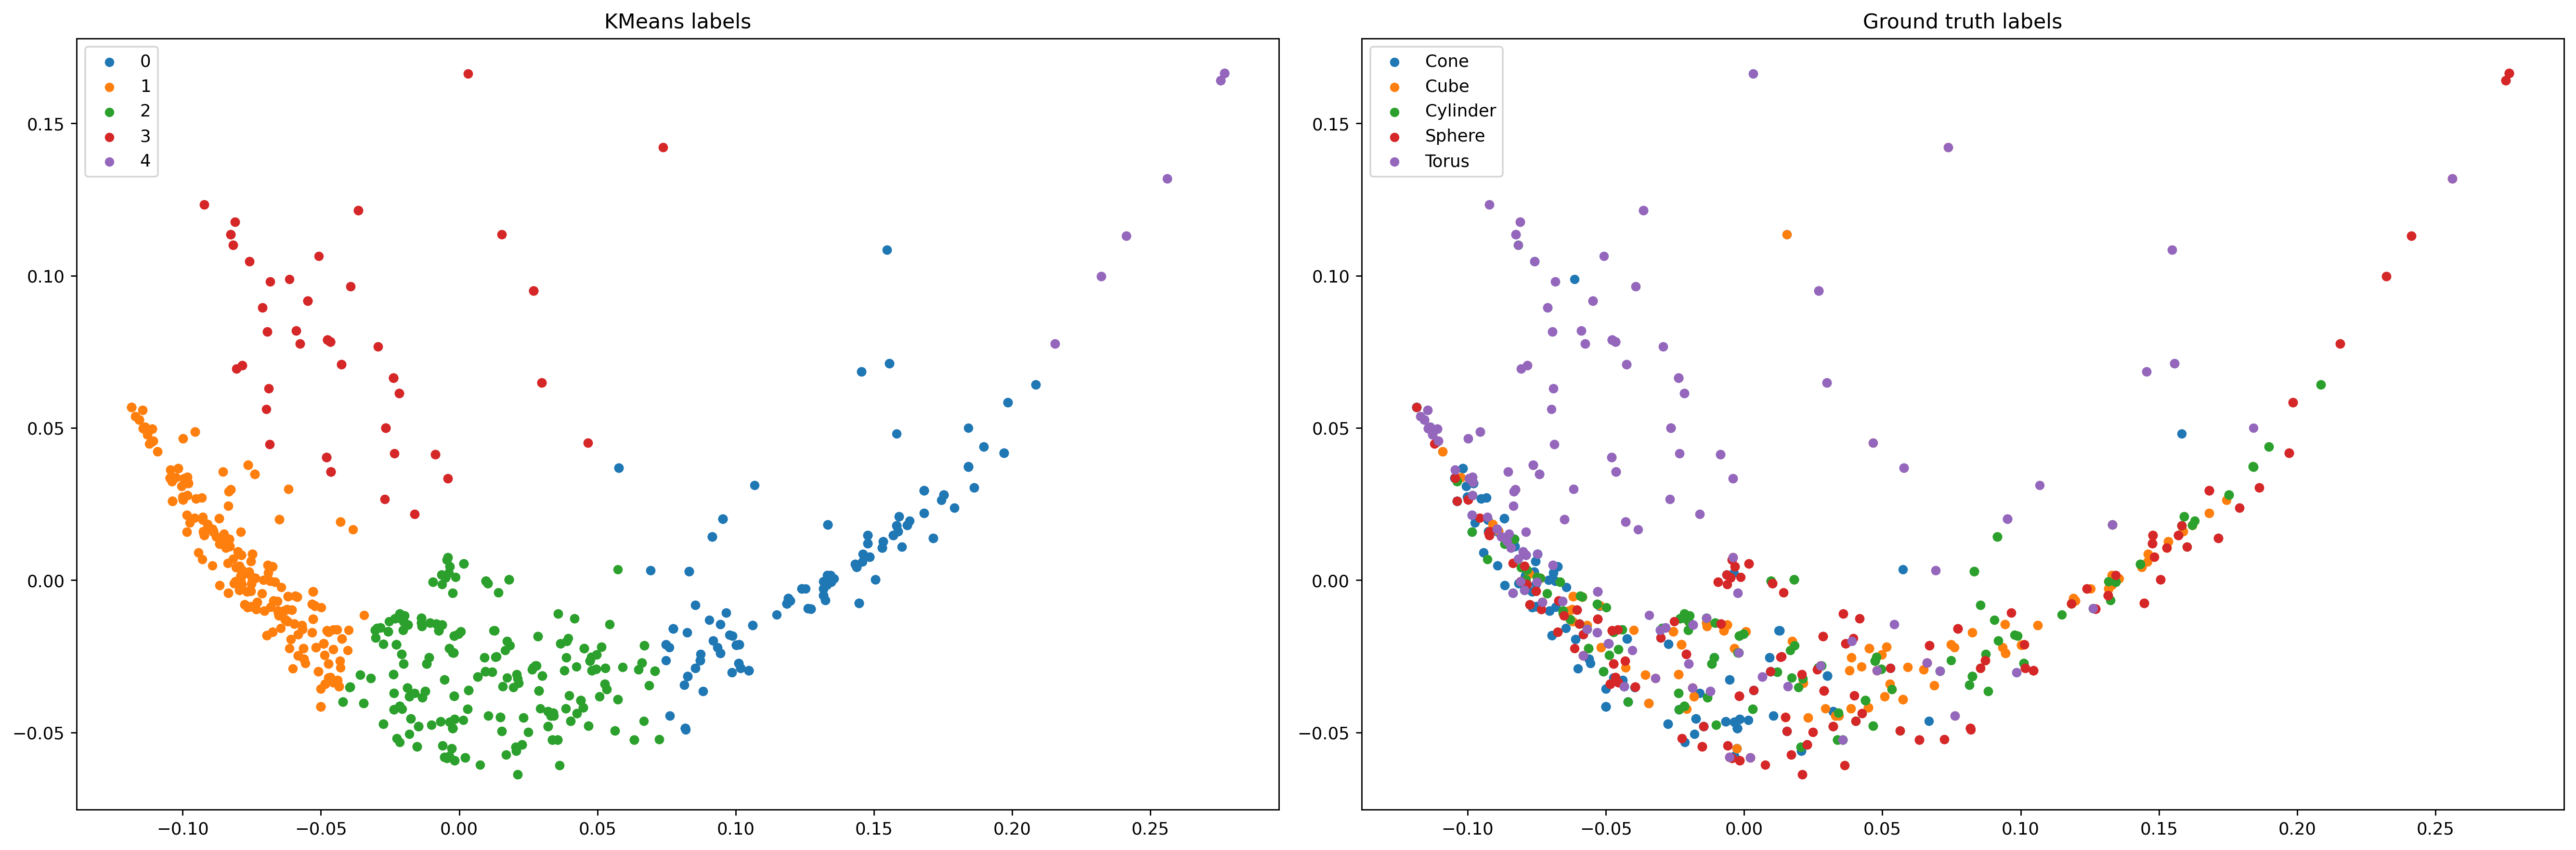

In [35]:
cluster_results.sort(key=lambda x: (x[1][1], x[1][2], x[1][1]), reverse=True)
log_info(cluster_results)